In [9]:
import gensim #pip install gensim
import pprint
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logging
import pyLDAvis.gensim #pip install pyLDAvis
import pyLDAvis.gensim_models
import time

''' 
 default_term_info = default_term_info.sort_values(
        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS
'''

" \n default_term_info = default_term_info.sort_values(\n        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS\n"

In [10]:
#1. Creazione del TF-IDF (Term Frequency - Inverse Document Frequency), assegnamo un peso ad ogni parola
#  - TF: frequenza del termine nel documento: num. occorrenze / num. totale di parole nel documento
#  - IDF: inverso della frequenza del termine nei documenti: log(num. totale di documenti / num. documenti che contengono il termine)
#  - TF-IDF: prodotto delle due precedenti (risulta elevato quando la parola è molto presente nel documento e poco presente negli altri documenti)

source = './doc/cleaned.csv'
df = pd.read_csv(source)

#Tokenizzazione
tweets = df['lemmatized_text'].apply(lambda text: word_tokenize(text))

# Create a dictionary
dictionary = corpora.Dictionary(tweets)

# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in tweets]

# Train the TF-IDF model
tfidf = models.TfidfModel(corpus)

# Transform the corpus into TF-IDF vectors
tfidf_corpus = tfidf[corpus]

In [11]:
# Show some results
for i, doc in enumerate(tfidf_corpus):
    if i > 1:
        break
    print(f"TF-IDF values for document {i}:")
    for token_id, tfidf_value in doc:
        word = dictionary[token_id]  # Get the word corresponding to the token_id
        print(f"Token ID: {token_id}, Word: {word}, TF-IDF Value: {tfidf_value}")
    print("\n")

TF-IDF values for document 0:
Token ID: 0, Word: abuse, TF-IDF Value: 0.08367081176638592
Token ID: 1, Word: abused, TF-IDF Value: 0.10565476670031988
Token ID: 2, Word: action, TF-IDF Value: 0.059251513516204064
Token ID: 3, Word: agency, TF-IDF Value: 0.3708231194736718
Token ID: 4, Word: along, TF-IDF Value: 0.07669101949950845
Token ID: 5, Word: call, TF-IDF Value: 0.1165749228074798
Token ID: 6, Word: came, TF-IDF Value: 0.07549083326324948
Token ID: 7, Word: can, TF-IDF Value: 0.10573642949458316
Token ID: 8, Word: clearly, TF-IDF Value: 0.08697462649913086
Token ID: 9, Word: comment, TF-IDF Value: 0.08201402900875147
Token ID: 10, Word: commission, TF-IDF Value: 0.09539865661781192
Token ID: 11, Word: comprehensive, TF-IDF Value: 0.09388865271636394
Token ID: 12, Word: either, TF-IDF Value: 0.07965358521501915
Token ID: 13, Word: elon, TF-IDF Value: 0.08798238719851235
Token ID: 14, Word: estimate, TF-IDF Value: 0.10219848476774687
Token ID: 15, Word: forcing, TF-IDF Value: 0.09

In [12]:
def execute_LDA(n_topic, corpus, dictionary, epochs):
    start_time = time.time()
    
    logging.basicConfig(level=logging.WARNING)
    
    #execute
    lda_model = LdaMulticore(
        corpus = corpus, #corpus in tfidf
        id2word = dictionary, #dizionario (vocabolario dei miei documenti)
        num_topics = n_topic,
        random_state = 42, #per riproducibilità
        passes = epochs,
        per_word_topics = True,
        workers = 3
        )
    
    '''#LDA TRAINING
    lda_model = LdaModel(
    corpus = corpus, #corpus in tfidf
    id2word = dictionary, #dizionario (vocabolario dei miei documenti)
    alpha = 'auto',
    eta = 'auto',
    num_topics = n_topic,
    random_state = 42, #per riproducibilità
    passes = epochs,
    per_word_topics = True) #aggiunge maggiori info'''
    
    #save model
    lda_model.save(f'models/lda_model_{n_topic}_{epochs}')
    
    
    # Compute Coherence Score u_mass
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
    coherence_umass = coherence_model_lda.get_coherence()
    
    # Compute Coherence Score c_v
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
    coherence_cv = coherence_model_lda_cv.get_coherence()
    
    end_time = time.time()
    
    return lda_model, coherence_umass, coherence_cv, end_time - start_time

def print_topic(num, lda_model):
    topics = lda_model.show_topics(num_topics=num, num_words=10)  # You can adjust the number of words as needed
    print("\n----- TOPIC -----")
    i = 0
    for topic in topics:
        i = i + 1
        topic_words = topic[1].split("+")
        words = [word.split("*")[1].strip() for word in topic_words]
        topic_str = ', '.join(words)
        print(f"Topic{i}: {topic_str}")
    #lda_model.show_topics(formatted=False)
    

In [13]:
#Execute LDA
n_topics = []
coherence_umass = []
coherence_cv = []
epochs = 100

for i in range(6,21):
    print(f"\n\nExecuting LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, umass, cv, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(i, model)
    



Executing LDA with 6 topics and 100 epochs


Execution time: 12.402 min
Coherence umass: -9.652 e Coherence cv: 0.522

----- TOPIC -----
Topic1: "american", "amp", "year", "family", "act", "job", "work", "community", "working", "need"
Topic2: "trump", "biden", "election", "republican", "president", "vote", "say", "house", "gop", "democrat"
Topic3: "elder", "larry", "roe", "newsom", "wade", "antisemitism", "da", "trans", "dnc", "jewish"
Topic4: "happy", "day", "honor", "sacrifice", "birthday", "wishing", "today", "texas", "service", "thank"
Topic5: "pact", "afghanistan", "rail", "tuberville", "exposed", "editor", "toxic", "withdrawal", "benefit", "tester"
Topic6: "bob", "ukraine", "russia", "putin", "china", "russian", "minister", "ukrainian", "israel", "older"


Executing LDA with 7 topics and 100 epochs
Execution time: 13.519 min
Coherence umass: -8.412 e Coherence cv: 0.564

----- TOPIC -----
Topic1: "border", "american", "biden", "republican", "tax", "debt", "cost", "security", "people", "price"
Topic2: "trump", "biden", "elec

N.Topics: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Coherence score: [-9.65220408856567, -8.412156249864863, -8.85039075317813, -9.783709945659847, -9.363410900632312, -8.101922976573372, -9.146749039660161, -8.151216665898627, -9.77385397937696, -9.160011977954117, -11.43264450465686, -10.102876891519207, -10.213456154115175, -8.039297698426921, -9.69608460972133]


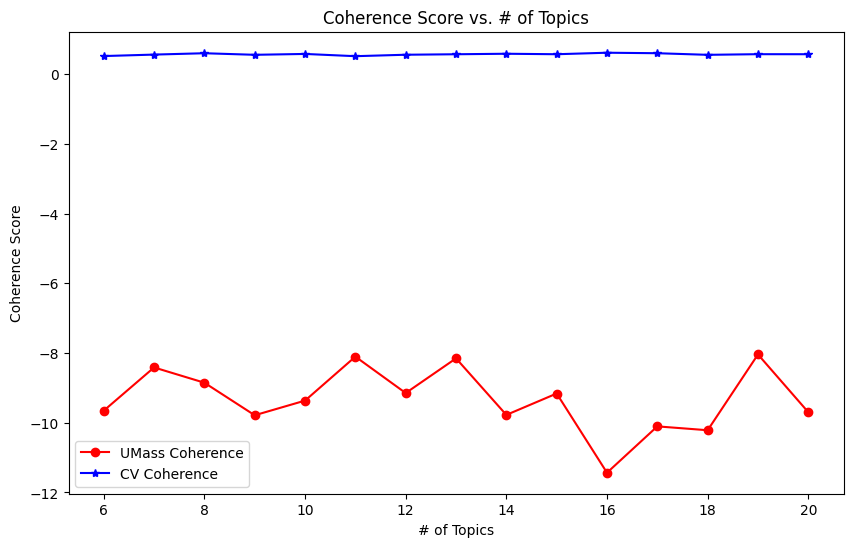

In [14]:

# Load the saved LDA model
#lda_model_up = LdaModel.load("lda_model")

print("N.Topics:", n_topics)
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(n_topics, coherence_umass, marker='o', color='red', label='UMass Coherence')
plt.plot(n_topics, coherence_cv, marker='*', color = 'blue', label = 'CV Coherence')
plt.legend(loc='best')
plt.title('Coherence Score vs. # of Topics')
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [15]:
#pyLDAvis (https://siqi-zhu.medium.com/ldavis-a-deep-dive-into-the-popular-topic-modeling-tool-d0c61a03e969)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_visualization.html')